# Laplace's equation

In [2]:
# Import libraries.
from matplotlib import pyplot, cm
from mpl_toolkits import mplot3d
import numpy

%matplotlib inline

In [3]:
# Change default font family and size for Matplotlib figures.
pyplot.rc('font', family='serif', size=16)

## Problem setup

Solve the Laplace's equation $\nabla^2 u = 0$ in the domain $\Omega = \left[ 0, L_x \right] \times \left[ 0, L_y \right]$

<img src="figures/application_setup.png" alt="application_setup" width="300"/>

Initial guess: $u = 0$ everywhere inside the domain.

## Analytical solution

$$
u \left( x, y \right) = \frac{\sinh \left( \frac{3}{2} \pi \frac{y}{L_y} \right)}{\sinh \left( \frac{3}{2} \pi \frac{L_x}{L_y} \right)} \sin \left( \frac{3}{2} \pi \frac{x}{L_x} \right)
$$

In [4]:
def laplace_solution(x, y, Lx, Ly):
    """Return the analytical solution.

    Parameters
    ----------
    x : numpy.ndarray
        Coordinates along the x direction as a 1D array of floats.
    y : numpy.ndarray
        Coordinates along the y direction as a 1D array of floats.
    Lx : float
        Length of the domain in the x direction.
    Ly : float
        Length of the domain in the y direction.

    Returns
    -------
    u : numpy.ndarray
        The analytical solution as a 2D array of floats.

    """
    X, Y = numpy.meshgrid(x, y)
    u = (numpy.sinh(1.5 * numpy.pi * Y / Ly) /
         numpy.sinh(1.5 * numpy.pi * Ly / Lx) *
         numpy.sin(1.5 * numpy.pi * X / Lx))
    
    return u

In [5]:
def plot_3d(x, y, u, label='$z$', elev=30.0, azim=45.0):
    """Create a 3D surface plot of the scalar field `u`.

    Parameters
    ----------
    x : numpy.ndarray
        Gridline locations in the x direction as a 1D array of floats.
    y : numpy.ndarray
        Gridline locations in the y direction as a 1D array of floats.
    u : numpy.ndarray
        Scalar field to plot as a 2D array of floats.
    label : string, optional
        Axis label to use in the third direction; default: 'z'.
    elev : float, optional
        Elevation angle in the z plane; default: 30.0.
    azim : float, optional
        Azimuth angle in the x,y plane; default: 45.0.

    """
    fig = pyplot.figure(figsize=(8.0, 6.0))
    ax = mplot3d.Axes3D(fig)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel(label)
    X, Y = numpy.meshgrid(x, y)
    ax.plot_surface(X, Y, u, cmap=cm.viridis)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(y[0], y[-1])
    ax.view_init(elev=elev, azim=azim)

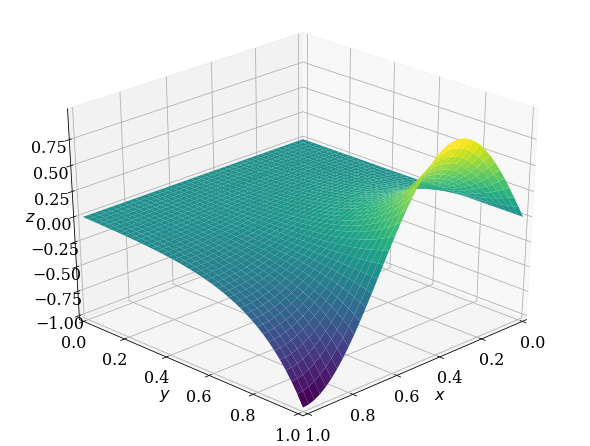

In [6]:
# Set parameters.
Lx, Ly = 1.0, 1.0  # lengths of the domain
nx, ny = 41, 41  # number of points along each direction

# Define grid-point locations.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

u_exact = laplace_solution(x, y, Lx, Ly)
plot_3d(x, y, u_exact)

## Initial solution

<img src="figures/application_setup.png" alt="application_setup" width="300"/>

Initial guess: $u = 0$ everywhere inside the domain.

Boundary values:

* Bottom and left: $u = 0$
* Top: $u = \sin \left( \frac{3}{2} \pi \frac{x}{L_x} \right)$
* Right: $\frac{\partial u}{\partial x} = 0$

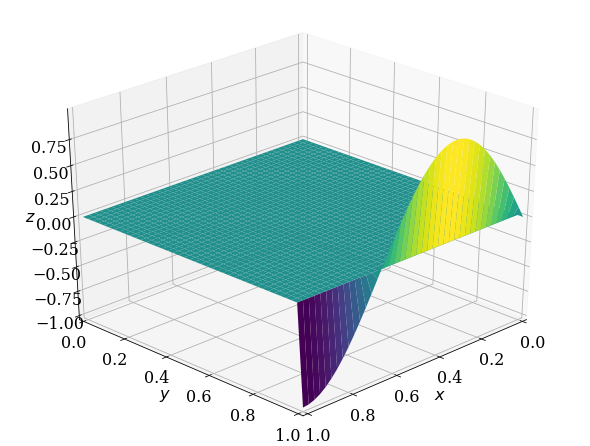

In [7]:
#initial conditions
u0 = numpy.zeros((ny, nx))
u0[-1, :] = numpy.sin(1.5 * numpy.pi * x / Lx)

plot_3d(x, y, u0)

u0_2 = u0.copy()
u0_2[1:-1, 1:-1] = 2.0

## Jacobi method

$$
u_{i, j}^{k+1} = \frac{1}{4} \left( u_{i, j-1}^k + u_{i-1, j}^k + u_{i+1, j}^k + u_{i, j+1}^k \right)
$$

In [8]:
def laplace_2d_jacobi(u0, maxiter=20000, rtol=1e-8):
    """Solve the 2D Laplace equation using Jacobi method.

    Parameters
    ----------
    u0 : numpy.ndarray
        The initial solution as a 2D array of floats.
    maxiter : integer, optional
        Maximum number of iterations to perform; default: 20000.
    rtol : float, optional
        Relative tolerance for convergence; default: 1e-8.

    Returns
    -------
    u : numpy.ndarray
        The solution after relaxation as a 2D array of floats.
    ite : integer
        The number of iterations computed.
    diff : float
        The final relative L2-norm of the difference.

    """
    u = u0.copy()  # create copy to not overwrite initial guess
    diff = rtol + 1.0  # initialize residual to "high" value
    ite = 0  # initialize iteration index
    while diff > rtol and ite < maxiter:
        un = u.copy()  # store the solution at previous iteration
        
        #iterating using the jocabo method
        u[1:-1, 1:-1] = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] +
                                u[:-2, 1:-1] + u[2:, 1:-1])
        
        #neumann conditions at the right boundary
        u[1:-1, -1] = u[1:-1, -2]
        
        #l2 norm of the difference
        diff = numpy.linalg.norm(u - un) / numpy.linalg.norm(un)
        ite += 1

    return u, ite, diff

Jacobi relaxation: 4473 iterations to reach a relative difference of 9.989253685041417e-09


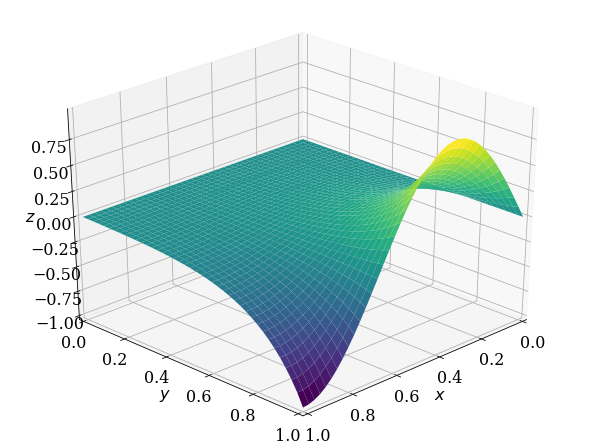

In [9]:
#getting the numerical solution
u, ites, diff = laplace_2d_jacobi(u0, rtol=1e-8)
print('Jacobi relaxation: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(diff))

#plotting the numerical solution
plot_3d(x, y, u)


## Convergence analysis

In [10]:
# List of grid-spacing sizes to investigate.
dx_vals = [0.1, 0.05, 0.025, 0.0125]

# Empty list to store the error on each grid.
errors = []

for dx in dx_vals:
    
    nx = int(Lx / dx) + 1
    ny = int(Ly / dx) + 1
    x = numpy.linspace(0.0, Lx, num=nx)
    y = numpy.linspace(0.0, Ly, num=ny)
    
    u0 = numpy.zeros((ny, nx))
    u0[-1, :] = numpy.sin(1.5 * numpy.pi * x / Lx)
    
    u, ites, diff = laplace_2d_jacobi(u0)
    
    u_exact = laplace_solution(x, y, Lx, Ly)
    
    error = numpy.linalg.norm(u - u_exact) / numpy.linalg.norm(u_exact)
    
    errors.append(error)

   
    

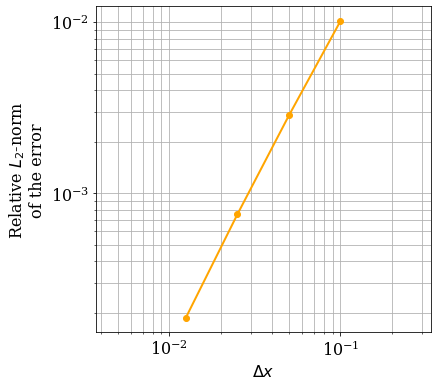

In [16]:
#plotting the error values
pyplot.figure(figsize=(6.0, 6.0))
pyplot.xlabel(r'$\Delta x$')
pyplot.ylabel('Relative $L_2$-norm\nof the error')
pyplot.grid(which='both')
pyplot.loglog(dx_vals, errors, color='orange', linestyle='-', linewidth=2, marker='o')
pyplot.axis('equal');

## 2nd-order Neumann boundary conditions

In [12]:
def laplace_2d_jacobi_neumann(u0, maxiter=20000, rtol=1e-8):
    """Solve the 2D Laplace equation using Jacobi method.

    Use a second-order approximation for Neumann boundary conditions.

    Parameters
    ----------
    u0 : numpy.ndarray
        The initial solution as a 2D array of floats.
    maxiter : integer, optional
        Maximum number of iterations to perform; default: 20000.
    rtol : float, optional
        Relative tolerance for convergence; default: 1e-8.

    Returns
    -------
    u : numpy.ndarray
        The solution after relaxation as a 2D array of floats.
    ite : integer
        The number of iterations performed.
    diff : float
        The final relative L2-norm of the difference.

    """
    u = u0.copy()  # create copy to not overwrite initial guess
    diff = rtol + 1.0  # initialize residual to "high" value
    ite = 0  # initialize iteration index
    while diff > rtol and ite < maxiter:
        un = u.copy()  # store the solution at previous iteration
        
        #iterating using the jocabo method
        u[1:-1, 1:-1] = 0.25 * (un[1:-1, :-2] + un[1:-1, 2:] +
                                un[:-2, 1:-1] + un[2:, 1:-1])
        
        #neumann conditions at the right boundary
        u[1:-1, -1] = 0.25 * (2.0 * un[1:-1, -2] +
                              un[2:, -1] + un[:-2, -1])
        
        #l2 norm of the difference
        diff = numpy.linalg.norm(u - un) / numpy.linalg.norm(un)
        ite += 1
        
    return u, ite, diff

Jacobi relaxation: 8661 iterations to reach a relative difference of 9.994166636403097e-09


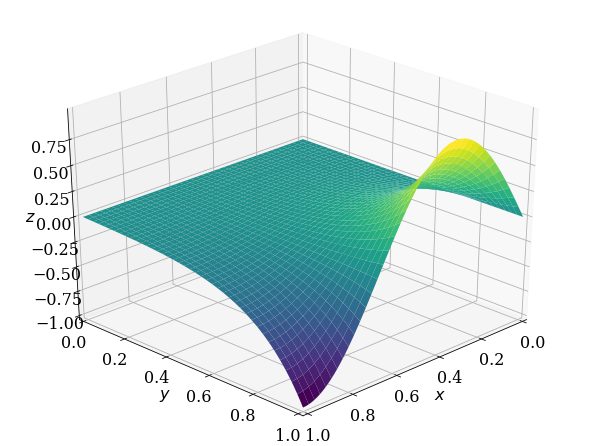

In [13]:
#getting the numerical solution
u, ites, diff = laplace_2d_jacobi_neumann(u0, rtol=1e-8)
print('Jacobi relaxation: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(diff))

#plotting the numerical solution
plot_3d(x, y, u)


## Re-do convergence analysis

In [14]:
# List of grid-spacing sizes to investigate.
dx_vals = [0.1, 0.05, 0.025, 0.0125]

# Empty list to store the error on each grid.
errors = []

for dx in dx_vals:
    nx = int(Lx / dx) + 1
    ny = int(Ly / dx) + 1
    x = numpy.linspace(0.0, Lx, num=nx)
    y = numpy.linspace(0.0, Ly, num=ny)
    
    u0 = numpy.zeros((ny, nx))
    u0[-1, :] = numpy.sin(1.5 * numpy.pi * x / Lx)
    
    u, ites, diff = laplace_2d_jacobi_neumann(u0)
    
    u_exact = laplace_solution(x, y, Lx, Ly)
    
    error = numpy.linalg.norm(u - u_exact) / numpy.linalg.norm(u_exact)
    
    errors.append(error)

    

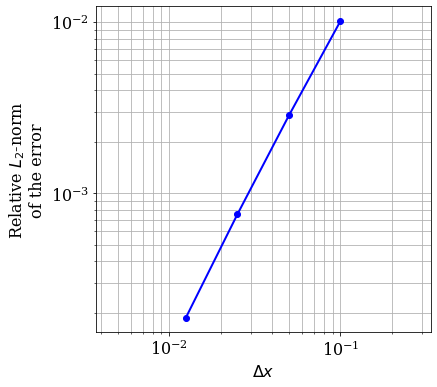

In [15]:
#plotting the error values
pyplot.figure(figsize=(6.0, 6.0))
pyplot.xlabel(r'$\Delta x$')
pyplot.ylabel('Relative $L_2$-norm\nof the error')
pyplot.grid(which='both')
pyplot.loglog(dx_vals, errors, color='blue', linestyle='-', linewidth=2, marker='o')
pyplot.axis('equal');
